#Start

In [1]:
%cd /content/drive/MyDrive/wingding-OCR-white

/content/drive/MyDrive/wingding-OCR-white


Dataset splits:
Train set size: 4383
Validation set size: 939
Test set size: 940

Number of unique characters: 62

Displaying sample images from training set:


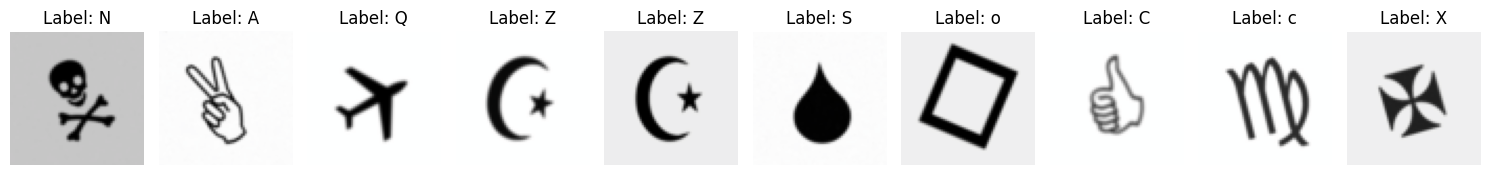


Test batch shapes:
Images shape: torch.Size([4, 3, 64, 64])
Labels shape: torch.Size([4])


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class WingdingsDataset(Dataset):
    def __init__(self, df, label_to_idx, transform=None):
        self.df = df
        self.label_to_idx = label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label_idx = torch.tensor(self.label_to_idx[label], dtype=torch.long)

        return image, label_idx

def load_and_process_data(metadata_path, img_size=64):
    # Read metadata
    df = pd.read_csv(metadata_path)

    # Create label mappings
    unique_labels = sorted(df['label'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}

    # Create train/validation/test splits (70/15/15)
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = WingdingsDataset(train_df, label_to_idx, transform=transform)
    val_dataset = WingdingsDataset(val_df, label_to_idx, transform=transform)
    test_dataset = WingdingsDataset(test_df, label_to_idx, transform=transform)

    return train_dataset, val_dataset, test_dataset, label_to_idx


def display_sample_images(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # Get the inverse mapping
    idx_to_label = {v: k for k, v in dataset.label_to_idx.items()}

    for i in range(num_samples):
        image, label_idx = dataset[i]
        # Denormalize the image
        image = image.numpy().transpose(1, 2, 0)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        label = idx_to_label[label_idx.item()]
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    metadata_path = "metadata.csv"

    # Load the data
    train_dataset, val_dataset, test_dataset, label_to_idx = load_and_process_data(metadata_path)

    # Read the original DataFrame for visualization
    df = pd.read_csv(metadata_path)

    # Print dataset statistics
    print(f"Dataset splits:")
    print(f"Train set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
    print(f"\nNumber of unique characters: {len(label_to_idx)}")


    # Display sample images
    print("\nDisplaying sample images from training set:")
    display_sample_images(train_dataset)

    # Test data loading
    test_loader = DataLoader(train_dataset, batch_size=4)
    images, labels = next(iter(test_loader))
    print("\nTest batch shapes:")
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from einops.layers.torch import Rearrange
import time

# Vision Transformer Model Components
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=64, patch_size=8, in_channels=3, embed_dim=192):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2

        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                     p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positions = nn.Parameter(torch.randn(num_patches + 1, embed_dim))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=192, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.att_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.att_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=192, num_heads=8, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, image_size=64, patch_size=8, in_channels=3, num_classes=62,
                 embed_dim=192, depth=12, num_heads=8, mlp_ratio=4., dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.transformer = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]  # Use CLS token only
        x = self.head(x)
        return x

from tqdm import tqdm
import time

def train_model(model, train_loader, val_loader, num_epochs, device, label_to_idx):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0

    print("Starting training...")
    print(f"Training on device: {device}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print("-" * 80)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training Phase
        model.train()
        train_loss, train_correct = 0, 0
        total_train = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        batch_losses = []
        batch_accuracies = []

        for batch_idx, (images, labels) in enumerate(train_bar):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # Calculate batch statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct = (predicted == labels).sum().item()
            train_correct += correct

            # Update batch metrics
            batch_loss = loss.item()
            batch_acc = (correct / labels.size(0)) * 100
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_acc)

            # Update progress bar
            train_bar.set_postfix({
                'loss': f'{batch_loss:.4f}',
                'acc': f'{batch_acc:.2f}%',
                'avg_loss': f'{np.mean(batch_losses):.4f}',
                'avg_acc': f'{np.mean(batch_accuracies):.2f}%'
            })

        # Validation Phase
        model.eval()
        val_loss, val_correct = 0, 0
        total_val = 0

        val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
        val_batch_losses = []
        val_batch_accuracies = []

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Calculate batch statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct = (predicted == labels).sum().item()
                val_correct += correct

                # Update batch metrics
                batch_loss = loss.item()
                batch_acc = (correct / labels.size(0)) * 100
                val_batch_losses.append(batch_loss)
                val_batch_accuracies.append(batch_acc)

                # Update progress bar
                val_bar.set_postfix({
                    'loss': f'{batch_loss:.4f}',
                    'acc': f'{batch_acc:.2f}%',
                    'avg_loss': f'{np.mean(val_batch_losses):.4f}',
                    'avg_acc': f'{np.mean(val_batch_accuracies):.2f}%'
                })

        # Calculate epoch metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / total_train
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / total_val

        # Save metrics for plotting
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
            print(f"New best model saved! Validation Accuracy: {epoch_val_acc:.2f}%")

        scheduler.step()

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"Time: {epoch_time:.2f}s")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Best Val Acc: {best_val_acc:.2f}%")
        print("-" * 80)

    return train_losses, train_accs, val_losses, val_accs


def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

def test_model(model, test_loader, device, idx_to_label):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)

            all_preds.extend(zip(predicted.cpu().numpy(), max_probs.cpu().numpy()))
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    correct = sum(1 for (pred, _), label in zip(all_preds, all_labels) if pred == label)
    accuracy = 100 * correct / len(all_labels)

    print(f"\nTest Accuracy: {accuracy:.2f}%")
    return all_preds, all_labels

# Main execution
if __name__ == "__main__":
    # Load your datasets
    train_dataset, val_dataset, test_dataset, label_to_idx = load_and_process_data("metadata.csv")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViT(
        image_size=64,
        patch_size=8,
        in_channels=3,
        num_classes=len(label_to_idx),
        embed_dim=192,
        depth=12,
        num_heads=8,
        mlp_ratio=4.,
        dropout=0.1
    ).to(device)

    # Print model summary
    print("\nModel Architecture:")
    print(model)
    print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print("-" * 80)

    # Train model
    num_epochs = 3
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, num_epochs, device, label_to_idx
    )

    # Plot training curves
    plot_training_curves(train_losses, train_accs, val_losses, val_accs)

In [7]:
# Assuming you have the ViT model defined in the same script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model with the same configuration as during training
model = ViT(
    image_size=64,
    patch_size=8,
    in_channels=3,
    num_classes=len(label_to_idx),  # Number of classes should be same as in training
    embed_dim=192,
    depth=12,
    num_heads=8,
    mlp_ratio=4.,
    dropout=0.1
).to(device)

# Load the trained model weights
model.load_state_dict(torch.load('best_vit_model.pth'))
model.eval()  # Set the model to evaluation mode


<ipython-input-7-44e03cd3b658>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))


ViT(
  (patch_embed): PatchEmbedding(
    (projection): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
      (1): Linear(in_features=192, out_features=192, bias=True)
    )
  )
  (transformer): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (att_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=192, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=768, out_features=192, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Trans

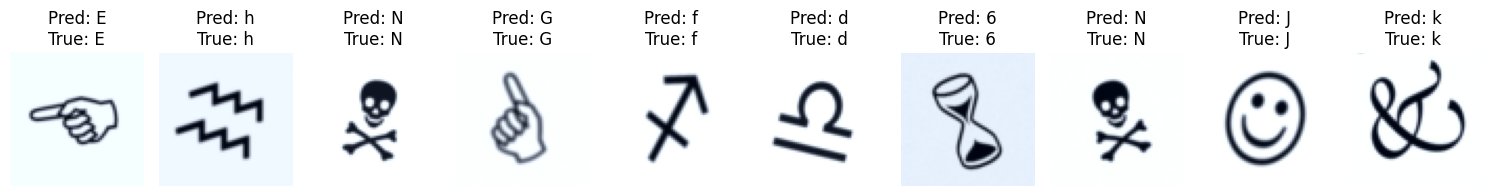

In [14]:
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from PIL import Image

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Use batch_size=1 for single image predictions

# Set up the plot
plt.figure(figsize=(15, 10))

for i, (img, label) in enumerate(test_loader):
    if i >= 10:
        break

    img = img.to(device)
    label = label.to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(img)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)

    predicted_label_idx = predicted.item()
    predicted_label = idx_to_label[predicted_label_idx]
    correct_label = idx_to_label[label.item()]

    # Display the image and predicted label
    plt.subplot(1, 10, i + 1)
    img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format for plt
    img = (img * 0.229 + 0.485)  # Denormalize
    img = np.clip(img, 0, 1)  # Ensure pixel values are valid

    plt.imshow(img)
    plt.title(f"Pred: {predicted_label}\nTrue: {correct_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()